In [1]:
# File I/O and Linear Algebra (Necessities)
import numpy as np
import pandas as pd
from math import sqrt

# Data Visualization
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

# Imports accuracy, precision, tools, etc.
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import metrics, set_config
from scipy.optimize import fmin_tnc
from scipy.stats import linregress
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, classification_report, f1_score, accuracy_score

In [2]:
# Read in our dataset
# DDOS_Dataset.csv contains DOS attack data from the University of New Brunswick (CSE-CIC-IDS2018)
df = pd.read_csv("../Bousquet_Project/DDOS_Dataset.csv")

In [3]:
# Check our dataset for N/A Values
df.isna().sum().to_numpy()

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 2277,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [4]:
# Drop features which contain N/A values (In this case: Flow Byts/s)
clean_data = df.dropna()
#useful_data = df[['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Label']]
clean_data.isna().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [5]:
# Examine possible features
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046298 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1046298 non-null  int64  
 1   Protocol           1046298 non-null  int64  
 2   Timestamp          1046298 non-null  object 
 3   Flow Duration      1046298 non-null  int64  
 4   Tot Fwd Pkts       1046298 non-null  int64  
 5   Tot Bwd Pkts       1046298 non-null  int64  
 6   TotLen Fwd Pkts    1046298 non-null  int64  
 7   TotLen Bwd Pkts    1046298 non-null  int64  
 8   Fwd Pkt Len Max    1046298 non-null  int64  
 9   Fwd Pkt Len Min    1046298 non-null  int64  
 10  Fwd Pkt Len Mean   1046298 non-null  float64
 11  Fwd Pkt Len Std    1046298 non-null  float64
 12  Bwd Pkt Len Max    1046298 non-null  int64  
 13  Bwd Pkt Len Min    1046298 non-null  int64  
 14  Bwd Pkt Len Mean   1046298 non-null  float64
 15  Bwd Pkt Len Std    1046298 non-n

In [6]:
# Show how many observations are contained within each of the three possible labels
print(df["Label"].value_counts())

# Save numerical values to a list for future data visualization
val_list = df["Label"].value_counts().to_list()

Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64


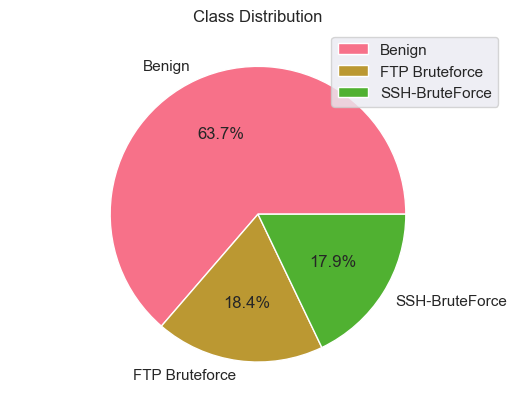

In [7]:
# Create a pie chart to demonstrate current data spread in each class relative to each other
# Note: We remove SSH data for simplicity of our model
labels = ["Benign", "FTP Bruteforce", "SSH-BruteForce"]
sizes = [val_list[0], val_list[1], val_list[2]]
sns.set_theme(palette='husl')
plt.axis("equal")
plt.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.legend(loc="upper right")
plt.title("Class Distribution")
plt.show()

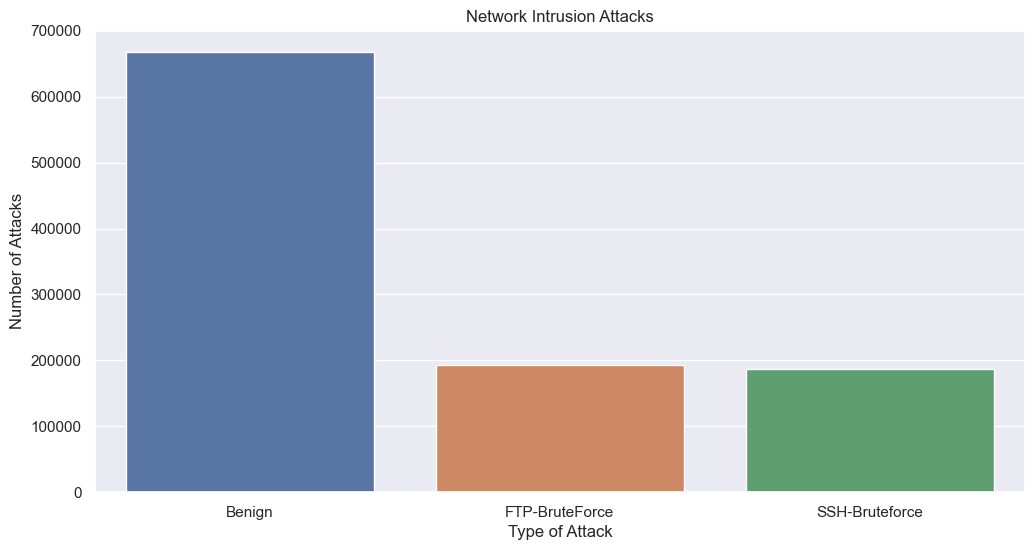

In [8]:
# Bar graph showing the same information as our pie chart
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Type of Attack')
ax = sns.countplot(x='Label', data=df)
ax.set(xlabel='Type of Attack', ylabel='Number of Attacks')
plt.title('Network Intrusion Attacks')
plt.show()

In [9]:
# Dilineate between columns containing strings and numerical data for use in Pearson Correllation Map
str_feats = []
for column_name, column_value in df.items():
    if type(column_value[1]) == str:
        str_feats.append(column_name)
        
# Grab the numerical columns by taking everything that is not categorical
num_feats = df.columns.difference(str_feats)
df_feats = df[num_feats]
df_feats.shape

(1048575, 78)

<Axes: title={'center': 'Pearson Correlation of Features'}>

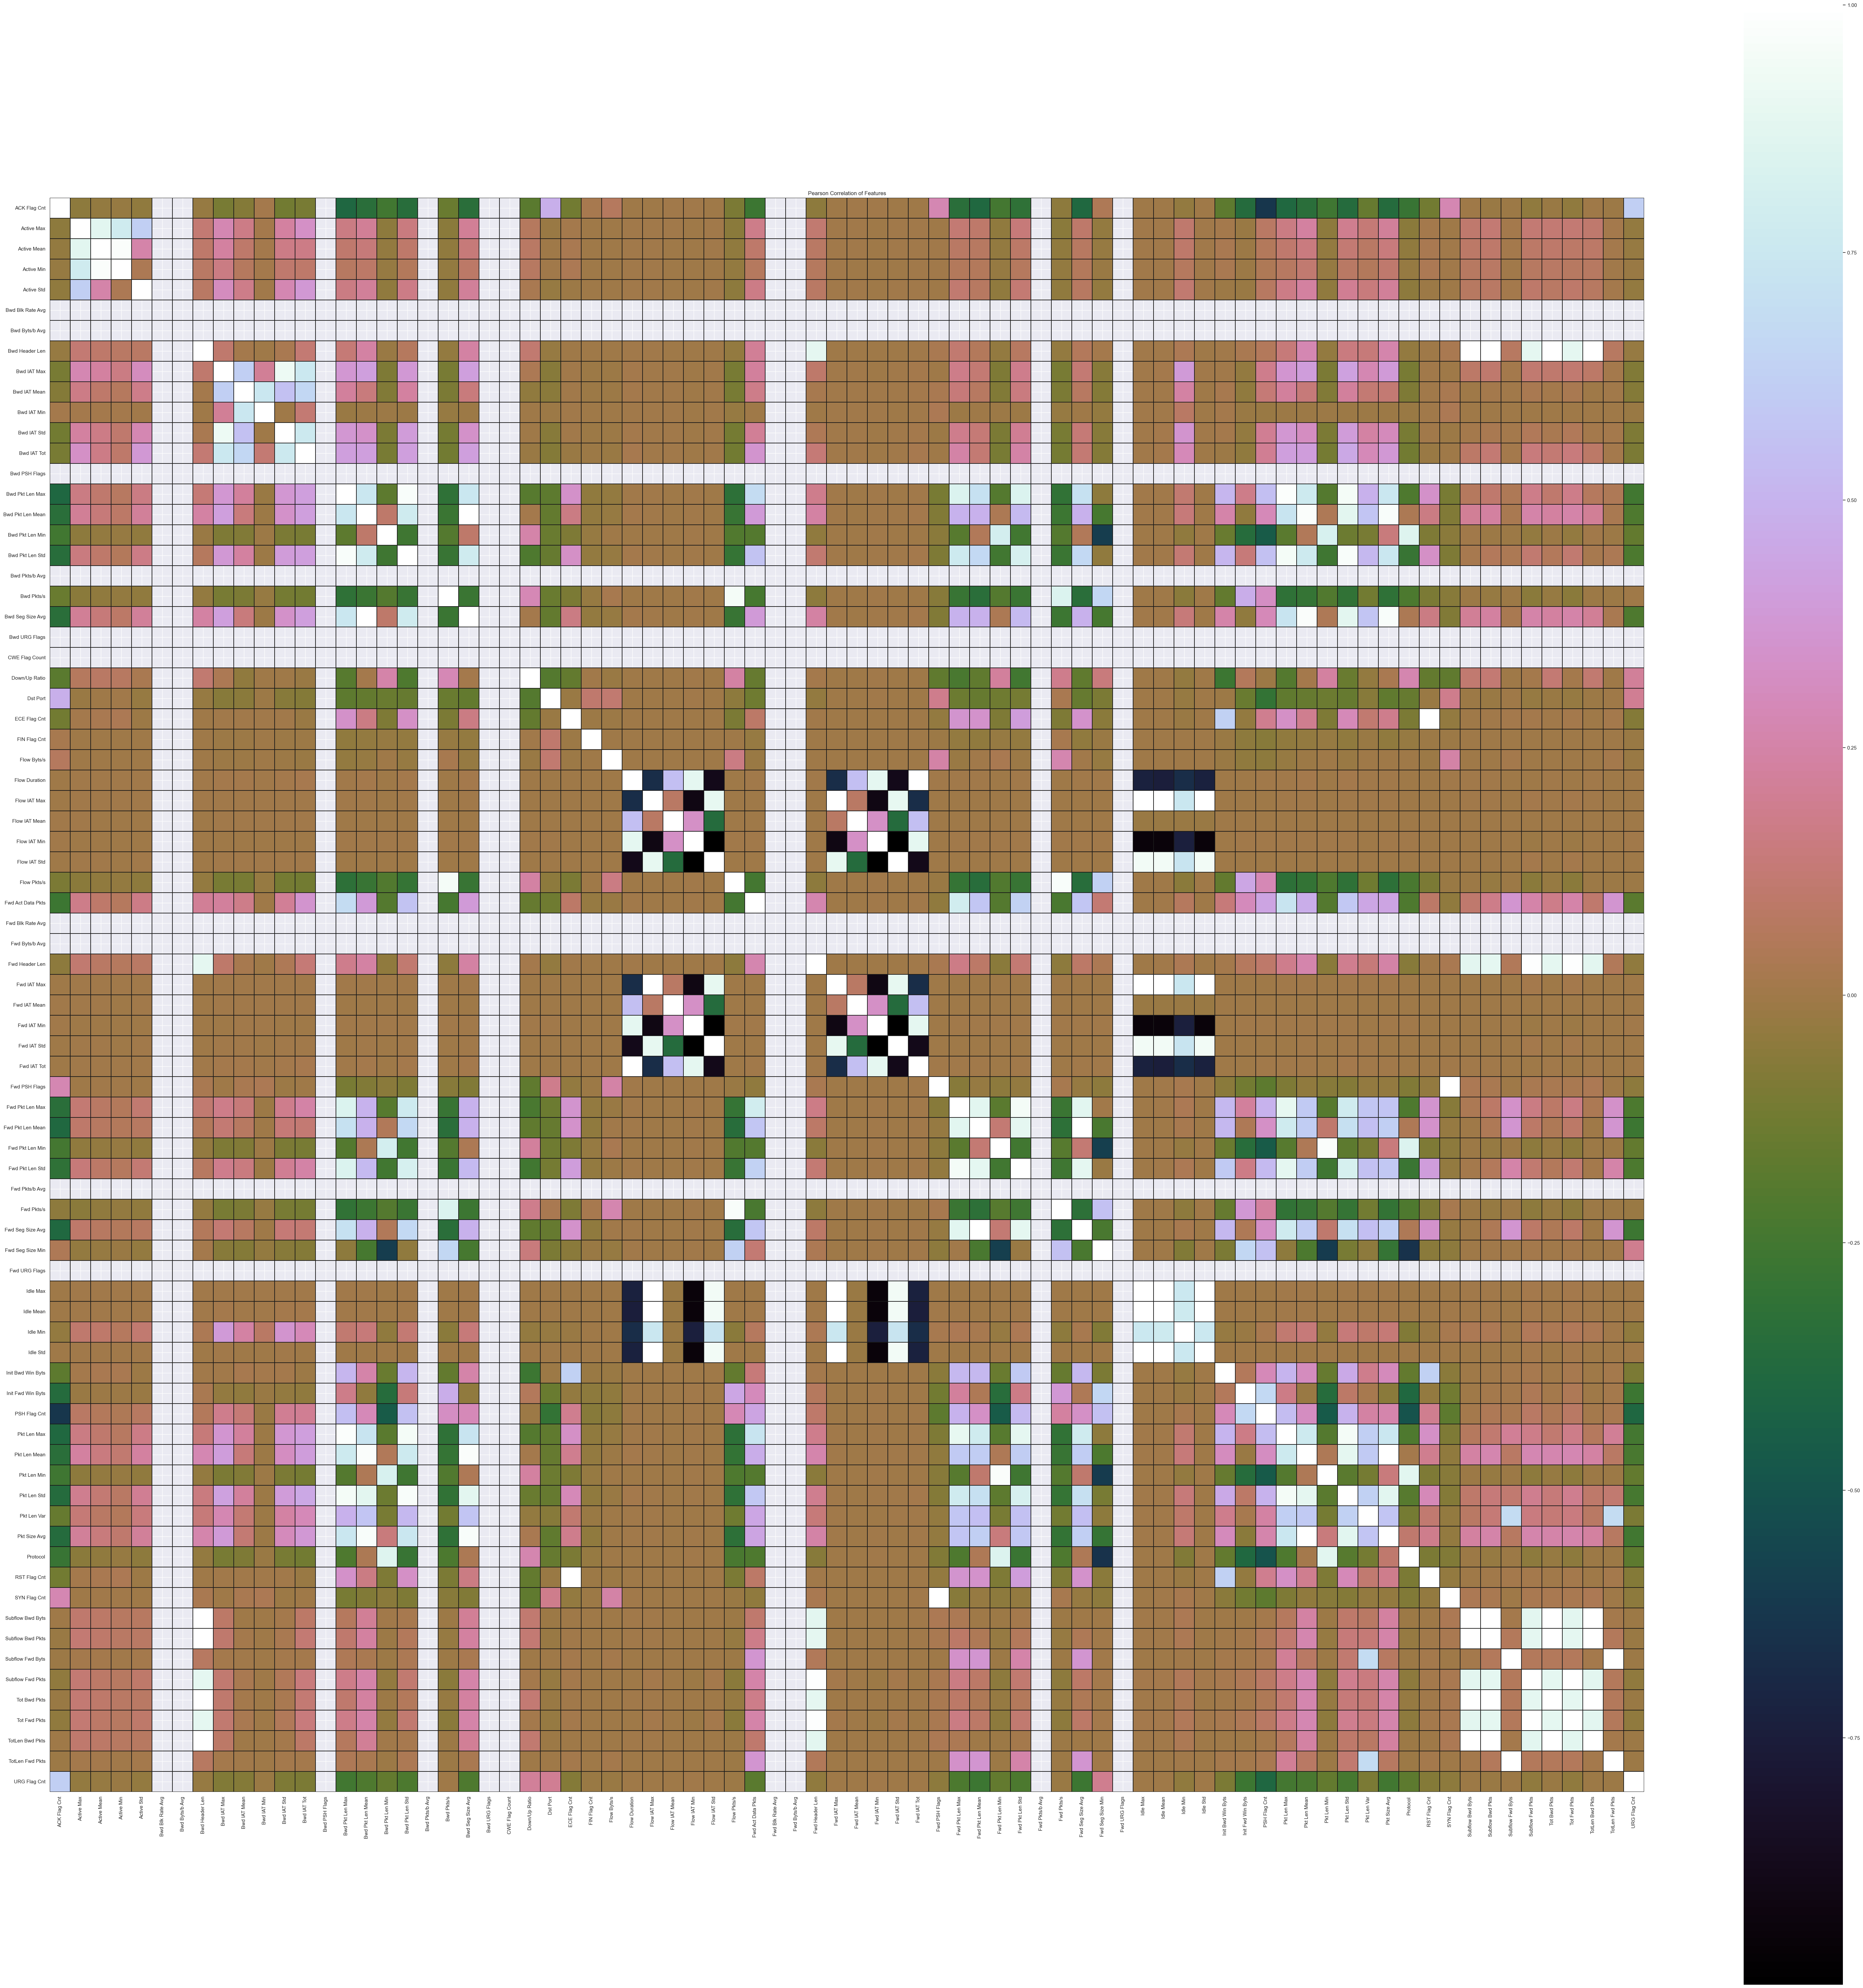

In [10]:
# Create a heatmap using Pearson Correlation
f, ax = plt.subplots(figsize=(78, 78))
plt.title("Pearson Correlation of Features")
sns.heatmap(df_feats.astype(float).corr(), linewidths=0.05, vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=False)

In [11]:
# Drop our SSH-BruteForce category for less computational complexity
df1 = clean_data[clean_data["Label"] == "Benign"][:180000]
df2 = clean_data[clean_data["Label"] == "FTP-BruteForce"][:180000]
df3 = clean_data[clean_data["Label"] == "SSH-BruteForce"][:180000]
df = pd.concat([df1, df2, df3], axis=0)

In [12]:
# Show how many observations are contained within each of the two possible labels
print(df["Label"].value_counts())

# Save numerical values to a list for future data visualization
val_list = df["Label"].value_counts().to_list()

Benign            180000
FTP-BruteForce    180000
Name: Label, dtype: int64


In [13]:
# Drop variables with no substantive data from the dataset
df.drop('Bwd Blk Rate Avg', axis=1, inplace=True)
df.drop('Bwd Byts/b Avg', axis=1, inplace=True)
df.drop('Bwd PSH Flags', axis=1, inplace=True)
df.drop('Bwd Pkts/b Avg', axis=1, inplace=True)
df.drop('Fwd Pkts/b Avg', axis=1, inplace=True)
df.drop('Fwd URG Flags', axis=1, inplace=True)
df.drop('Bwd URG Flags', axis=1, inplace=True)
df.drop('CWE Flag Count', axis=1, inplace=True)
df.drop('Fwd Blk Rate Avg', axis=1, inplace=True)
df.drop('Fwd Byts/b Avg', axis=1, inplace=True)

In [14]:
# Drop features with a very high negative or positive correlation to another variable
# We do this to keep computational complexity down since one of the two correlated values can be used
df.drop('Idle Mean', axis=1, inplace=True)
df.drop('Idle Std', axis=1, inplace=True)
df.drop('Idle Max', axis=1, inplace=True)
df.drop('Idle Min', axis=1, inplace=True)
df.drop('Flow IAT Std', axis=1, inplace=True)
df.drop('Flow IAT Max', axis=1, inplace=True)
df.drop('Flow IAT Min', axis=1, inplace=True)
df.drop('Flow Byts/s', axis=1, inplace=True)
df.drop('Fwd IAT Max', axis=1, inplace=True)
df.drop('Fwd IAT Std', axis=1, inplace=True)
df.drop('Bwd IAT Std', axis=1, inplace=True)
df.drop('Bwd Pkt Len Std', axis=1, inplace=True)
df.drop('Bwd Seg Size Avg', axis=1, inplace=True)
df.drop('Flow Pkts/s', axis=1, inplace=True)
df.drop('Bwd Header Len', axis=1, inplace=True)
df.drop('Fwd Header Len', axis=1, inplace=True)
df.drop('Subflow Fwd Pkts', axis=1, inplace=True)
df.drop('Subflow Fwd Byts', axis=1, inplace=True)
df.drop('Subflow Bwd Byts', axis=1, inplace=True)
df.drop('Subflow Bwd Pkts', axis=1, inplace=True)
df.drop('Tot Fwd Pkts', axis=1, inplace=True)
df.drop('Tot Bwd Pkts', axis=1, inplace=True)
df.drop('TotLen Bwd Pkts', axis=1, inplace=True)
df.drop('Fwd IAT Mean', axis=1, inplace=True)
df.drop('Fwd IAT Min', axis=1, inplace=True)
df.drop('Fwd IAT Tot', axis=1, inplace=True)
df.drop('Fwd Seg Size Min', axis=1, inplace=True)
df.drop('Fwd Pkts/s', axis=1, inplace=True)
df.drop('PSH Flag Cnt', axis=1, inplace=True)
df.drop('Pkt Len Max', axis=1, inplace=True)
df.drop('Bwd Pkts/s', axis=1, inplace=True)
df.drop('Init Fwd Win Byts', axis=1, inplace=True)
df.drop('Fwd Pkt Len Std', axis=1, inplace=True)
df.drop('Init Bwd Win Byts', axis=1, inplace=True)
df.drop('Pkt Size Avg', axis=1, inplace=True)
df.drop('Pkt Len Min', axis=1, inplace=True)
df.drop('Pkt Len Mean', axis=1, inplace=True)
df.drop('Pkt Len Std', axis=1, inplace=True)
df.drop('RST Flag Cnt', axis=1, inplace=True)
df.drop('SYN Flag Cnt', axis=1, inplace=True)
df.drop('Fwd Seg Size Avg', axis=1, inplace=True)
df.drop('ACK Flag Cnt', axis=1, inplace=True)
df.drop('Active Mean', axis=1, inplace=True)
df.drop('Timestamp', axis=1, inplace=True)
df.drop('Protocol', axis=1, inplace=True)

In [15]:
# Do the following again to prepare for our new heatmap
# Dilineate between columns containing strings and numerical data
str_feats = []
for column_name, column_value in df.items():
    if type(column_value[1]) == str:
        str_feats.append(column_name)
        
# Grab the numerical columns by taking everything that is not categorical
num_feats = df.columns.difference(str_feats)
df_feats = df[num_feats]
df_feats.shape

(360000, 24)

<Axes: title={'center': 'Pearson Correlation of Features'}>

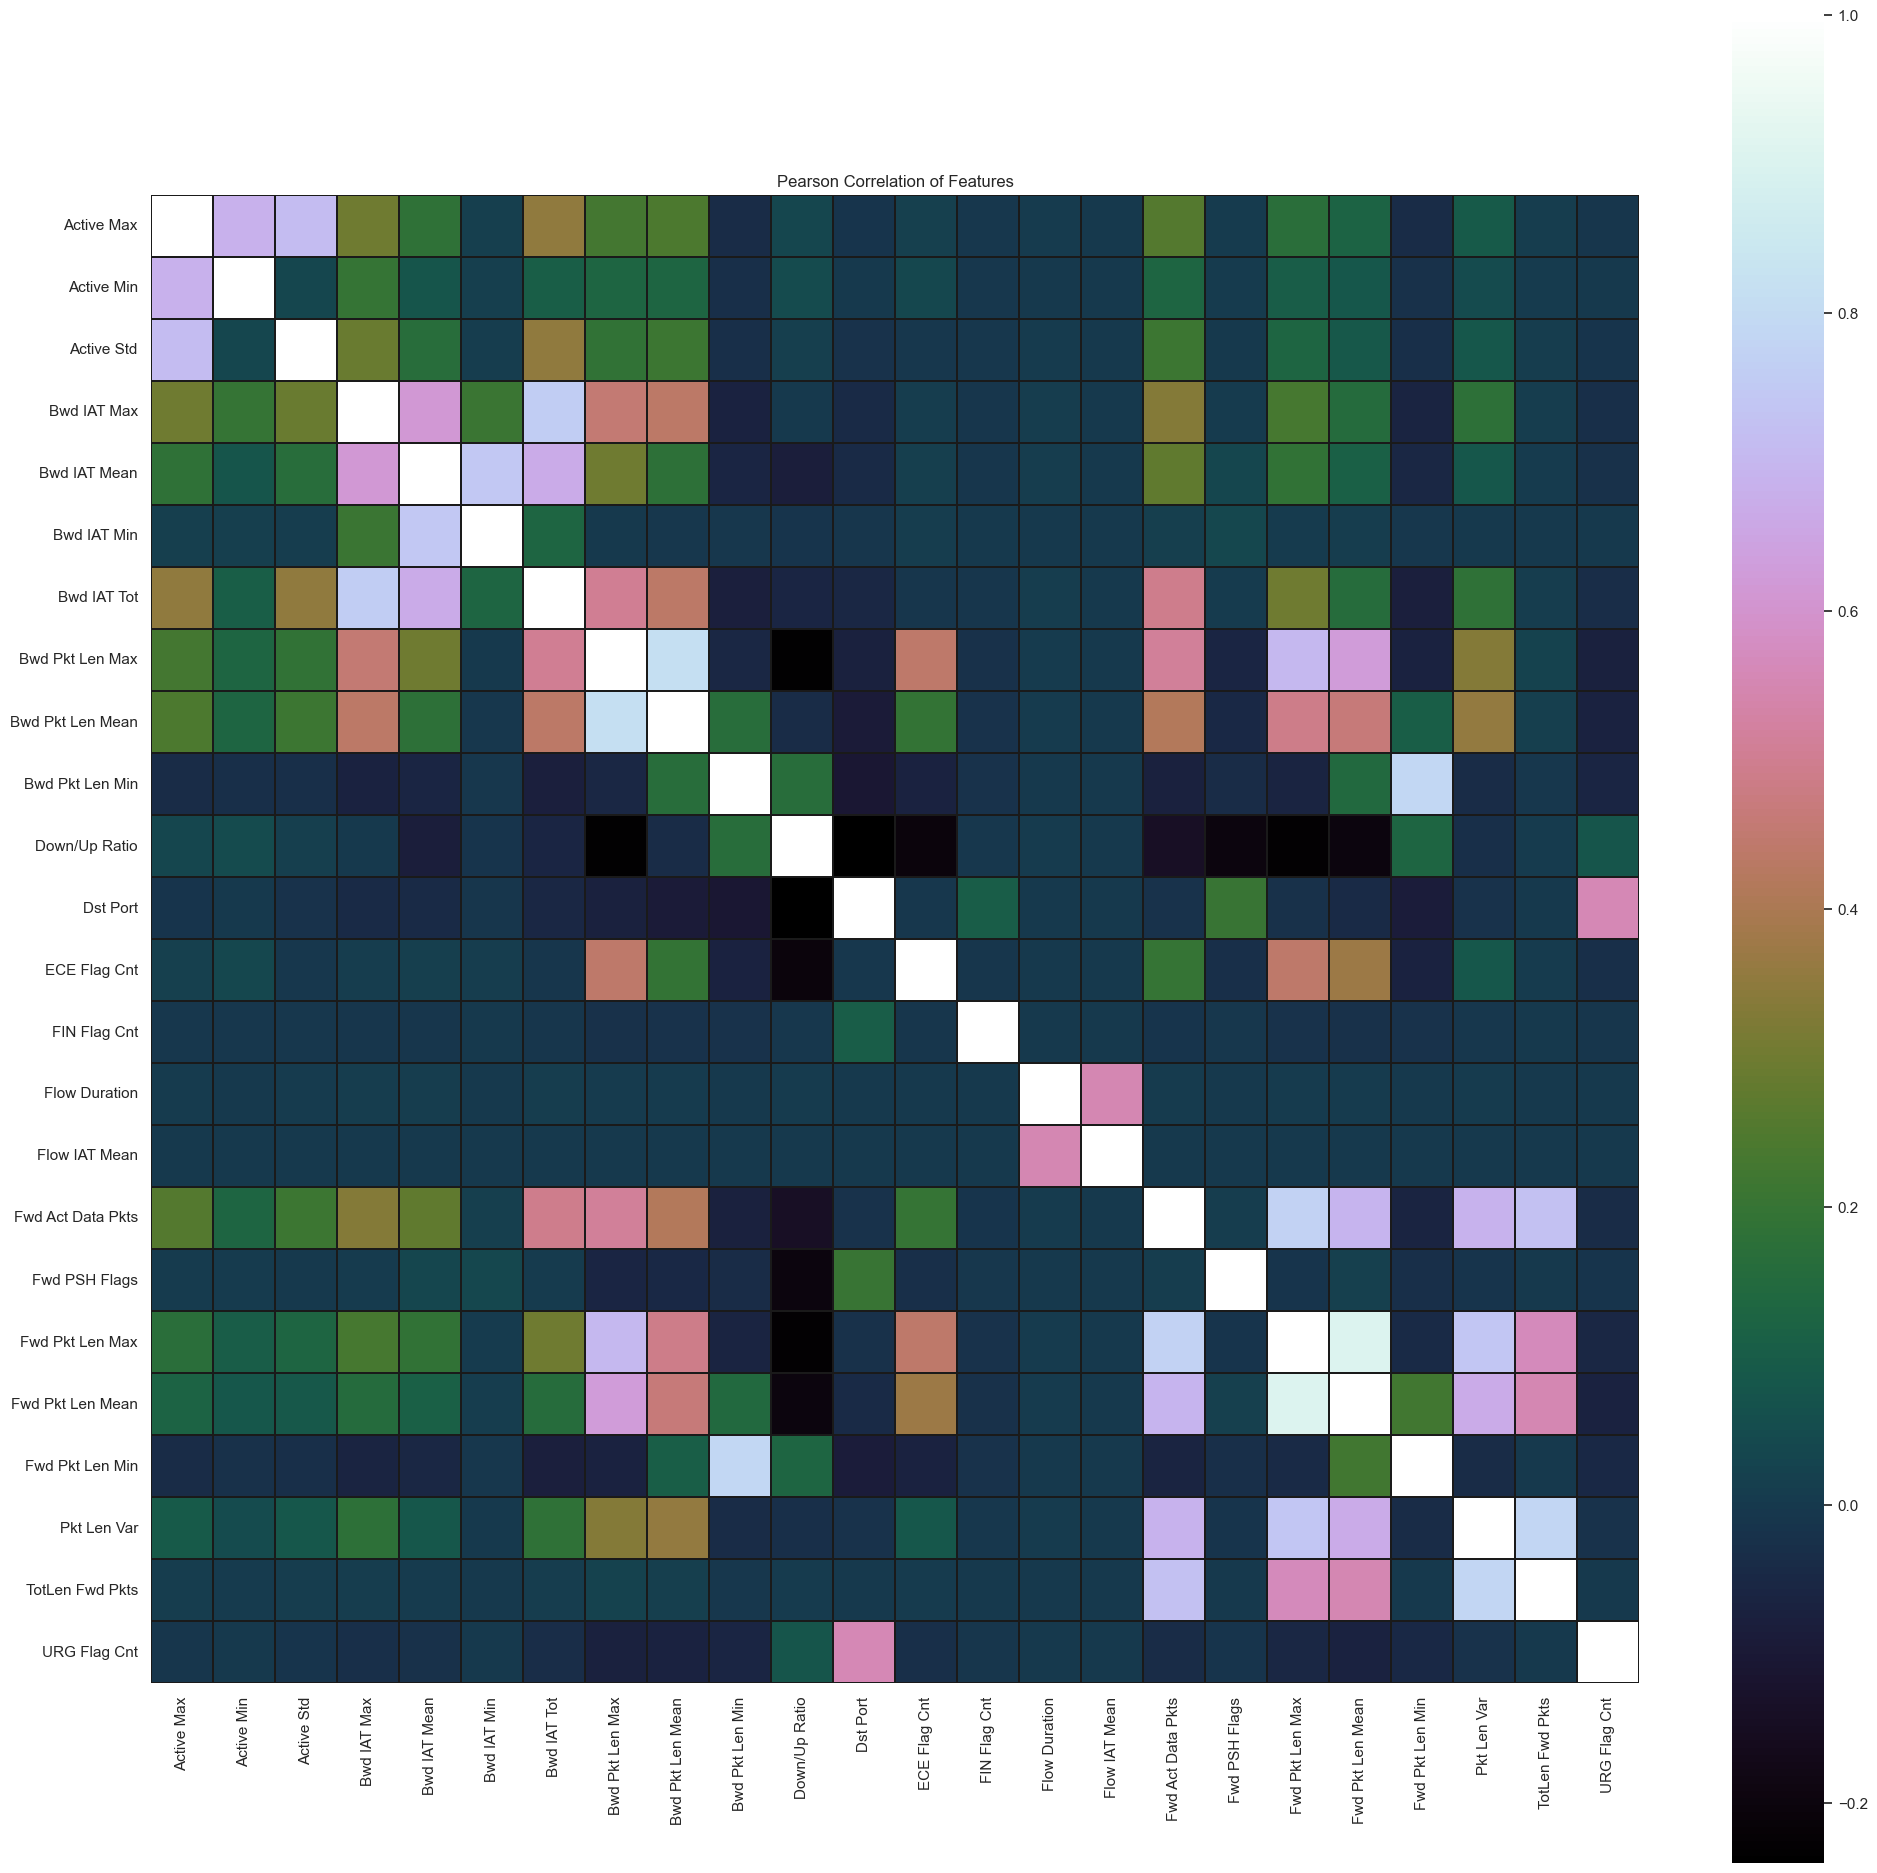

In [16]:
# Create a heatmap using Pearson Correlation
f, ax = plt.subplots(figsize=(24, 24))
plt.title("Pearson Correlation of Features")
sns.heatmap(df_feats.astype(float).corr(), linewidths=0.05, vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=False)

In [17]:
# Save a list of our possible features (column names)
features = df.columns
print(features)

Index(['Dst Port', 'Flow Duration', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Bwd IAT Tot',
       'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Pkt Len Var', 'FIN Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt',
       'Down/Up Ratio', 'Fwd Act Data Pkts', 'Active Std', 'Active Max',
       'Active Min', 'Label'],
      dtype='object')


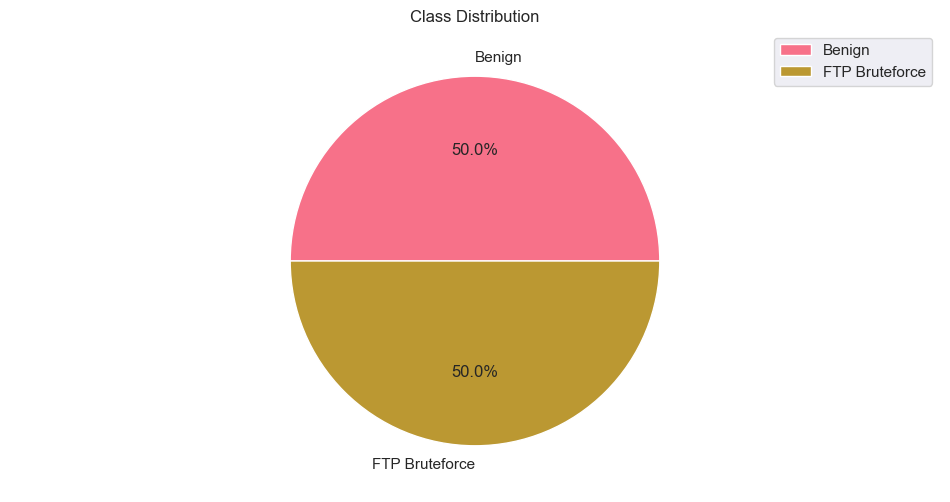

In [18]:
# Create a pie chart to demonstrate current data spread in each class relative to each other
# Note: We remove SSH data for simplicity of our model
labels = ["Benign", "FTP Bruteforce"]
sizes = [val_list[0], val_list[1]]
sns.set_theme(palette='husl')
plt.axis("equal")
plt.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.legend(loc="upper right")
plt.title("Class Distribution")
plt.show()

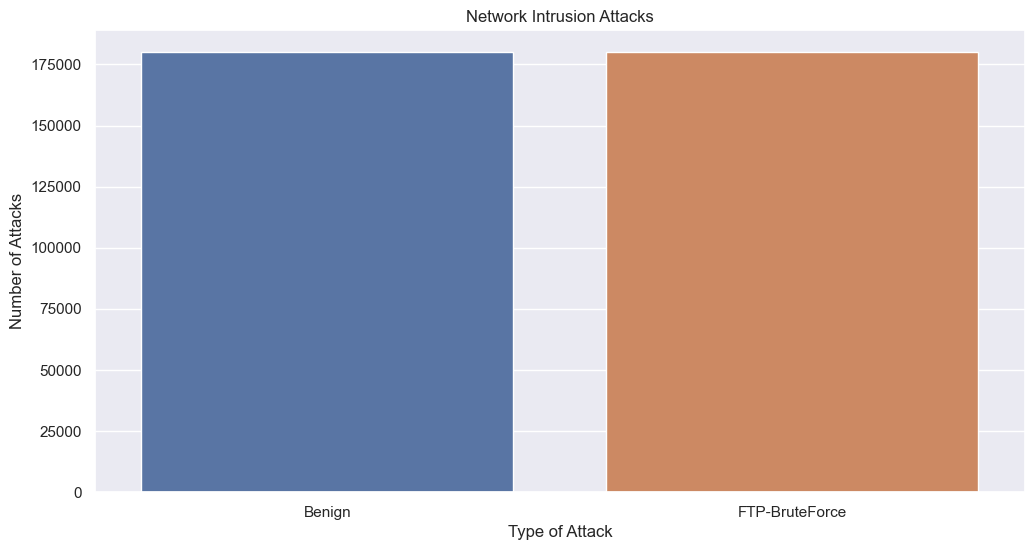

In [19]:
# Bar graph showing the same information as our pie chart
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Type of Attack')
ax = sns.countplot(x='Label', data=df)
ax.set(xlabel='Type of Attack', ylabel='Number of Attacks')
plt.title('Network Intrusion Attacks')
plt.show()

In [20]:
# Double check that we still have our two categories and that we did things correctly
df["Label"].value_counts()

Benign            180000
FTP-BruteForce    180000
Name: Label, dtype: int64

In [21]:
# Convert our string labels to integers for faster calculation
for i in range(len(df["Label"])):
    if df["Label"].values[i] == "Benign":
        df["Label"].values[i] = 0
    else:
        df["Label"].values[i] = 1

In [22]:
# Convert our labels to integers since python keeps them as string values
df["Label"].astype(str).astype(int)

0         0
1         0
2         0
3         0
4         0
         ..
355476    1
355477    1
355479    1
355486    1
355487    1
Name: Label, Length: 360000, dtype: int64

In [23]:
# Convert our column_names to a numpy array of strings to slap back on a dataframe after we mess around with it below
column_names = df.columns.to_numpy().tolist()

In [24]:
df.describe()

,Dst Port,Flow Duration,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Pkt Len Var,FIN Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Fwd Act Data Pkts,Active Std,Active Max,Active Min
count,360000.000000,3.600000e+05,3.600000e+05,360000.000000,360000.000000,360000.000000,360000.000000,360000.000000,360000.000000,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,360000.000000,3.600000e+05,360000.000000,360000.000000,360000.000000,360000.000000,360000.000000,3.600000e+05,3.600000e+05,3.600000e+05
mean,3718.259908,3.670314e+05,2.802986e+02,91.818431,6.413956,24.053978,189.514939,15.249108,63.187619,7.870283e+05,4.506483e+06,3.807350e+05,1.403947e+06,7.146965e+04,0.021500,2.157025e+04,0.002606,0.025239,0.034178,0.771456,1.073556,1.684272e+04,6.776028e+04,3.039453e+04
std,12723.593428,2.150548e+09,2.681666e+04,265.370205,18.116980,54.905356,414.499633,41.348062,146.095055,5.685899e+08,2.013021e+07,2.030902e+06,7.147299e+06,1.493320e+06,0.145044,1.708226e+05,0.050978,0.156850,0.181686,0.504002,4.270609,2.097327e+05,6.043517e+05,3.996923e+05
min,0.000000,-9.190110e+11,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.407010e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,21.000000,2.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,21.000000,2.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,80.000000,3.015675e+04,4.800000e+01,43.000000,0.000000,37.000000,102.000000,0.000000,68.000000,1.315300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.240333e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
max,65526.000000,1.199998e+08,8.591554e+06,64440.000000,1460.000000,11217.025225,1460.000000,688.000000,1459.079199,1.199797e+08,1.199886e+08,1.112793e+08,1.195640e+08,1.112793e+08,1.000000,7.762964e+07,1.000000,1.000000,1.000000,78.000000,1031.000000,5.677513e+07,8.036988e+07,5.017650e+07


In [25]:
# Convert all columns to float values and get rid of infinite values
clean_data = df.to_numpy()
clean_data = np.array(clean_data, dtype=float)
clean_data.astype(float)
clean_data = clean_data[np.isfinite(clean_data).all(1)]

In [26]:
# Convert numpy array of data back into a dataframe
clean_data = pd.DataFrame(clean_data)
clean_data.columns = column_names
clean_data

,Dst Port,Flow Duration,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Pkt Len Var,FIN Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Fwd Act Data Pkts,Active Std,Active Max,Active Min,Label
0,0.0,112641719.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.632086e+07,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,112641466.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.632073e+07,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,112638623.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.631931e+07,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22.0,6453966.0,1239.0,744.0,0.0,82.600000,976.0,0.0,227.300000,2.689152e+05,5637902.0,626433.555556,1167293.0,554.0,0.0,77192.153846,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
4,22.0,8804066.0,1143.0,744.0,0.0,81.642857,976.0,0.0,200.818182,3.668361e+05,7715481.0,771548.100000,2174893.0,90.0,0.0,78267.353846,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359995,21.0,7.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,7.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
359996,21.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
359997,21.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
359998,21.0,2.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,2.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


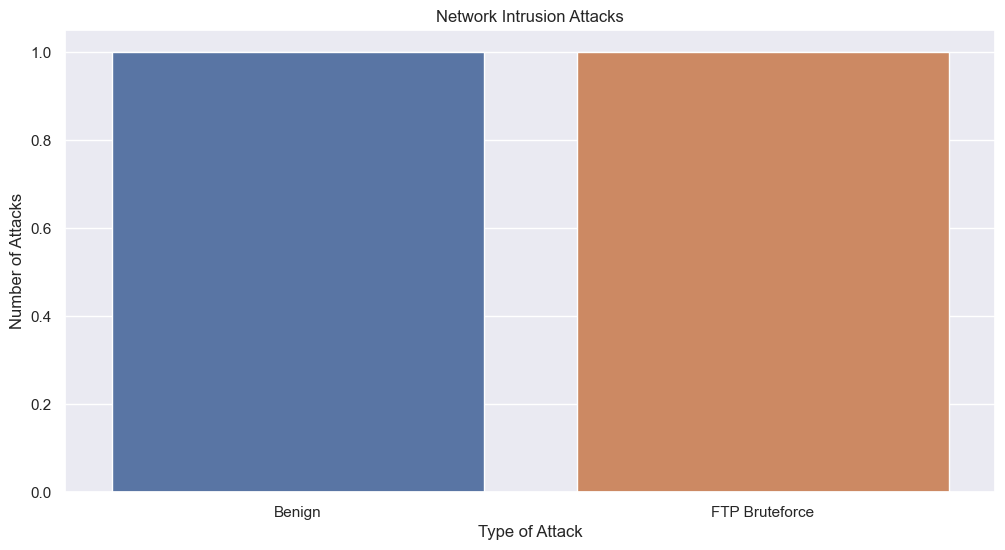

In [27]:
# Bar graph showing the same information as our pie chart
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Type of Attack')
ax = sns.countplot(x=labels, data=clean_data)
ax.set(xlabel='Type of Attack', ylabel='Number of Attacks')
plt.title('Network Intrusion Attacks')
plt.show()

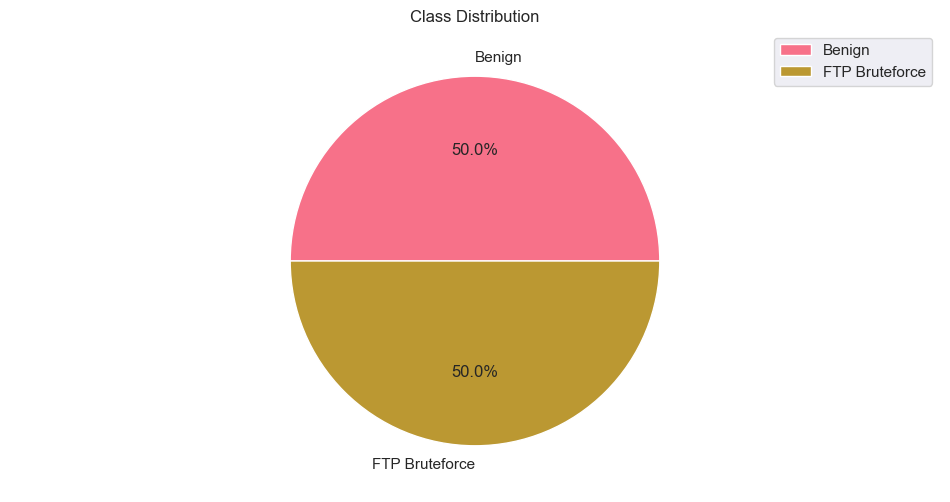

In [28]:
# Save numerical values to a list for future data visualization
val_list = clean_data["Label"].value_counts().to_list()
# Create a pie chart to demonstrate current data spread in each class relative to each other
# Note: We remove SSH data for simplicity of our model
labels = ["Benign", "FTP Bruteforce"]
sizes = [val_list[0], val_list[1]]
sns.set_theme(palette='husl')
plt.axis("equal")
plt.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.legend(loc="upper right")
plt.title("Class Distribution")
plt.show()

In [29]:
# Save our labels for while we normalize our dataset below
y = df["Label"]
clean_data = df.drop(columns=["Label"])

In [30]:
clean_data.describe()

,Dst Port,Flow Duration,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Pkt Len Var,FIN Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Fwd Act Data Pkts,Active Std,Active Max,Active Min
count,360000.000000,3.600000e+05,3.600000e+05,360000.000000,360000.000000,360000.000000,360000.000000,360000.000000,360000.000000,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,360000.000000,3.600000e+05,360000.000000,360000.000000,360000.000000,360000.000000,360000.000000,3.600000e+05,3.600000e+05,3.600000e+05
mean,3718.259908,3.670314e+05,2.802986e+02,91.818431,6.413956,24.053978,189.514939,15.249108,63.187619,7.870283e+05,4.506483e+06,3.807350e+05,1.403947e+06,7.146965e+04,0.021500,2.157025e+04,0.002606,0.025239,0.034178,0.771456,1.073556,1.684272e+04,6.776028e+04,3.039453e+04
std,12723.593428,2.150548e+09,2.681666e+04,265.370205,18.116980,54.905356,414.499633,41.348062,146.095055,5.685899e+08,2.013021e+07,2.030902e+06,7.147299e+06,1.493320e+06,0.145044,1.708226e+05,0.050978,0.156850,0.181686,0.504002,4.270609,2.097327e+05,6.043517e+05,3.996923e+05
min,0.000000,-9.190110e+11,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.407010e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,21.000000,2.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,21.000000,2.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,80.000000,3.015675e+04,4.800000e+01,43.000000,0.000000,37.000000,102.000000,0.000000,68.000000,1.315300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.240333e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
max,65526.000000,1.199998e+08,8.591554e+06,64440.000000,1460.000000,11217.025225,1460.000000,688.000000,1459.079199,1.199797e+08,1.199886e+08,1.112793e+08,1.195640e+08,1.112793e+08,1.000000,7.762964e+07,1.000000,1.000000,1.000000,78.000000,1031.000000,5.677513e+07,8.036988e+07,5.017650e+07


In [31]:
# Eliminate zeros and replace them with the mean values of the column 
clean_data = (clean_data - clean_data.mean()) / (clean_data.max() - clean_data.min())
clean_data.describe()

,Dst Port,Flow Duration,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Pkt Len Var,FIN Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Fwd Act Data Pkts,Active Std,Active Max,Active Min
count,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05
mean,1.578984e-19,1.385369e-22,-1.356939e-20,4.490235e-19,1.026340e-18,1.677670e-19,-3.979039e-17,-9.789700e-18,7.105427e-18,9.444606e-22,-1.421085e-18,6.908054e-19,7.894919e-19,-1.727014e-20,-5.684342e-18,1.147230e-19,4.736952e-19,8.052818e-18,2.021099e-17,5.822503e-19,1.578984e-19,1.801028e-19,-1.011537e-19,-1.381611e-19
std,1.941763e-01,2.339762e-03,3.121281e-03,4.118098e-03,1.240889e-02,4.894823e-03,2.839039e-01,6.009893e-02,1.001283e-01,1.668295e-03,1.677677e-01,1.825049e-02,5.977802e-02,1.341957e-02,1.450442e-01,2.200482e-03,5.097817e-02,1.568501e-01,1.816859e-01,6.461566e-03,4.142201e-03,3.694094e-03,7.519630e-03,7.965727e-03
min,-5.674480e-02,-9.998698e-01,-3.262491e-05,-1.424867e-03,-4.393120e-03,-2.144417e-03,-1.298048e-01,-2.216440e-02,-4.330650e-02,-9.996503e-01,-3.755759e-02,-3.421437e-03,-1.174222e-02,-6.422548e-04,-2.150000e-02,-2.778610e-04,-2.605556e-03,-2.523889e-02,-3.417778e-02,-9.890456e-03,-1.041276e-03,-2.966567e-04,-8.431055e-04,-6.057523e-04
25%,-5.642432e-02,-3.993222e-07,-3.262491e-05,-1.424867e-03,-4.393120e-03,-2.144417e-03,-1.298048e-01,-2.216440e-02,-4.330650e-02,-2.309207e-06,-3.755759e-02,-3.421437e-03,-1.174222e-02,-6.422548e-04,-2.150000e-02,-2.778610e-04,-2.605556e-03,-2.523889e-02,-3.417778e-02,2.930057e-03,-1.041276e-03,-2.966567e-04,-8.431055e-04,-6.057523e-04
50%,-5.642432e-02,-3.993026e-07,-3.262491e-05,-1.424867e-03,-4.393120e-03,-2.144417e-03,-1.298048e-01,-2.216440e-02,-4.330650e-02,-2.309154e-06,-3.755759e-02,-3.421437e-03,-1.174222e-02,-6.422548e-04,-2.150000e-02,-2.778610e-04,-2.605556e-03,-2.523889e-02,-3.417778e-02,2.930057e-03,-1.041276e-03,-2.966567e-04,-8.431055e-04,-6.057523e-04
75%,-5.552391e-02,-3.665143e-07,-2.703802e-05,-7.575796e-04,-4.393120e-03,1.154140e-03,-5.994174e-02,-2.216440e-02,3.298231e-03,-2.270621e-06,-3.755759e-02,-3.421437e-03,-1.174222e-02,-6.422548e-04,-2.150000e-02,-2.618834e-04,-2.605556e-03,-2.523889e-02,-3.417778e-02,2.930057e-03,-1.041276e-03,-2.966567e-04,-8.431055e-04,-6.057523e-04
max,9.432552e-01,1.301586e-04,9.999674e-01,9.985751e-01,9.956069e-01,9.978556e-01,8.701952e-01,9.778356e-01,9.566935e-01,3.497222e-04,9.624424e-01,9.965786e-01,9.882578e-01,9.993577e-01,9.785000e-01,9.997221e-01,9.973944e-01,9.747611e-01,9.658222e-01,9.901095e-01,9.989587e-01,9.997033e-01,9.991569e-01,9.993942e-01


In [32]:
clean_data["Label"] = y

In [33]:
clean_data["Label"].value_counts()

0    180000
1    180000
Name: Label, dtype: int64

In [34]:
# View of our data prior to shuffling
clean_data

,Dst Port,Flow Duration,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Pkt Len Var,FIN Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Fwd Act Data Pkts,Active Std,Active Max,Active Min,Label
0,-0.056745,1.221531e-04,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,0.000163,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,-0.00989,-0.001041,-0.000297,-0.000843,-0.000606,0
1,-0.056745,1.221528e-04,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,0.000163,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,-0.00989,-0.001041,-0.000297,-0.000843,-0.000606,0
2,-0.056745,1.221497e-04,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,0.000163,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,-0.00989,-0.001041,-0.000297,-0.000843,-0.000606,0
3,-0.056409,6.622489e-06,0.000112,0.010121,-0.004393,0.005219,0.538688,-0.022164,0.112477,-0.000002,0.009429,0.002208,-0.001979,-0.000637,-0.0215,0.000717,-0.002606,-0.025239,-0.034178,-0.00989,0.004778,-0.000297,-0.000843,-0.000606,0
4,-0.056409,9.179360e-06,0.000100,0.010121,-0.004393,0.005134,0.538688,-0.022164,0.094327,-0.000001,0.026744,0.003512,0.006448,-0.000641,-0.0215,0.000730,-0.002606,-0.025239,-0.034178,-0.00989,0.004778,-0.000297,-0.000843,-0.000606,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355476,-0.056424,-3.993167e-07,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,-0.000002,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,0.00293,-0.001041,-0.000297,-0.000843,-0.000606,1
355477,-0.056424,-3.993233e-07,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,-0.000002,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,0.00293,-0.001041,-0.000297,-0.000843,-0.000606,1
355479,-0.056424,-3.993233e-07,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,-0.000002,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,0.00293,-0.001041,-0.000297,-0.000843,-0.000606,1
355486,-0.056424,-3.993222e-07,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,-0.000002,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,0.00293,-0.001041,-0.000297,-0.000843,-0.000606,1


In [35]:
clean_data = clean_data.sample(n=len(clean_data))

In [36]:
# One last view of our data before pumping it through our models
clean_data

,Dst Port,Flow Duration,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Pkt Len Var,FIN Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Fwd Act Data Pkts,Active Std,Active Max,Active Min,Label
144376,-0.056424,-3.993189e-07,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,-2.309198e-06,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,0.00293,-0.001041,-0.000297,-0.000843,-0.000606,1
472457,0.739977,-3.992950e-07,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,-2.309134e-06,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,-0.00989,-0.001041,-0.000297,-0.000843,-0.000606,0
92750,-0.056424,-3.993233e-07,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,-2.309210e-06,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,0.00293,-0.001041,-0.000297,-0.000843,-0.000606,1
508000,-0.049984,5.434379e-06,0.000037,0.006598,-0.004393,0.006756,-0.025695,-0.022164,-0.017263,-5.611667e-07,-0.035657,-0.002738,-0.010193,-0.000453,-0.0215,0.000035,-0.002606,-0.025239,-0.034178,-0.00989,0.001869,-0.000297,0.002253,0.004353,0
407615,-0.055936,-3.978686e-07,-0.000029,-0.000990,0.014785,0.000352,-0.055832,0.134812,0.030713,-2.305287e-06,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000250,-0.002606,-0.025239,-0.034178,0.00293,-0.001041,-0.000297,-0.000843,-0.000606,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486084,0.916060,-3.991611e-07,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,-2.308773e-06,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,-0.00989,-0.001041,-0.000297,-0.000843,-0.000606,0
509247,-0.049984,1.267204e-04,0.000070,0.002346,-0.004393,0.001787,0.870195,-0.022164,0.546792,5.663303e-06,0.935612,0.042202,0.478861,-0.000642,-0.0215,0.005035,-0.002606,-0.025239,-0.034178,0.00293,0.005748,-0.000107,0.000126,0.000642,0
105048,-0.056424,-3.993048e-07,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,-2.309160e-06,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,0.00293,-0.001041,-0.000297,-0.000843,-0.000606,1
175922,-0.056424,-3.993222e-07,-0.000033,-0.001425,-0.004393,-0.002144,-0.129805,-0.022164,-0.043307,-2.309207e-06,-0.037558,-0.003421,-0.011742,-0.000642,-0.0215,-0.000278,-0.002606,-0.025239,-0.034178,0.00293,-0.001041,-0.000297,-0.000843,-0.000606,1


In [37]:
# Begin Modeling Here
print("Ready for Modeling")

Ready for Modeling
